> Universidade do Estado do Amazonas<br>Escola Superior de Tecnologia<br>Aluno: Natanael Lucena de Medeiros

# Mecânica dos Sólidos e dos Fluidos: Evoluindo uma treliça


## Introdução

*   Objetivo 1: Dada uma treliça, determinar a melhor área de seção transversal das barras para obter-se uma treliça ótima

*   Objetivo 2: Dada uma treliça, determinar as melhores áreas de seção transversal e os comprimentos das barras para obter-se uma treliça ótima



## Desenvolvimento das componentes da treliça

In [218]:
# Truss node
class Node:
  def __init__(self, key: str, pos: tuple):
    self.key = key
    self.x, self.y = pos
    self.adj_bars = set()

  def distance_to(self, node) -> float:
    return ((self.x-node.x)**2 + (self.y - node.y)**2)**0.5

  def update_pos(self, pos: tuple) -> None:
    self.x, self.y = pos
    for adj_bar in self.adj_bars: adj_bar.process_bar_length()

In [219]:
# Truss support node
class SupportNode(Node):
  def __init__(self, key: str, pos: tuple):
    super().__init__(key, pos)
    self.rx = 0.0  # kN
    self.ry = 0.0  # kN

In [220]:
# Truss bar
class Bar:  
  def __init__(self, key: str, area: float = 0.0005, especific_mass=7870, elasticity = 2*10**8):
    self.nodes : tuple[Node | SupportNode] = ()
    self.key = key
    self.l = 0.0  # m
    self.area = area  # m²
    self.f_int = 0.0  # kN
    self.f_virt = 0.0  # kN
    self.delta = 0.0  # mm
    self.especific_mass = especific_mass
    self.elasticity = elasticity
    self.mass = 0.0  # kg

  def set_force(self, force: float, virtual=False) -> None:
    if virtual: self.f_virt = force
    else: self.f_int = force

  def get_force(self, virtual=False) -> float:
    return self.f_virt if virtual else self.f_int

  def process_bar_length(self) -> None:
    self.l = self.nodes[0].distance_to(self.nodes[1])

In [221]:
from math import sin, cos, atan

# Truss
class Truss:
  def __init__(self, nodes: list):
    self.nodes: dict[str, Node | SupportNode] = dict((n.key, n) for n in nodes)
    self.bars: dict[str, Bar] = {}
    self.total_delta = 0.0  # mm

  @property
  def mass(self):
    return sum(b.l * b.area * b.especific_mass for b in self.bars.values())

  def add_bar(self, bar: Bar) -> None:
    if bar.key in self.bars:
      raise Exception(f"Bar {bar.key} already exists in the truss")
    node_keys = list(bar.key)
    for node_key in node_keys:
      if node_key not in self.nodes:
        raise Exception(f"Not possible to add bar {bar.key} because the node {node_key} does not exists in the truss")
    bar.nodes = (self.nodes[node_keys[0]], self.nodes[node_keys[1]])
    node1, node2 = bar.nodes
    node1.adj_bars.add(bar)
    node2.adj_bars.add(bar)
    bar.process_bar_length()
    self.bars[bar.key] = bar

  def add_bars(self, bars: list) -> None:
    for bar in bars: self.add_bar(bar)

  def update_node_pos(self, key: str, pos: tuple) -> None:
    if key not in self.nodes:
      raise Exception(f"Not possible to update node {key} because it does not exists in the truss")
    node = self.nodes[key]
    node.x, node.y = pos
    for adj_bar in node.adj_bars:
      self.bars[adj_bar.key].l =  adj_bar.nodes[0].distance_to(adj_bar.nodes[1])

  def process_bars_delta(self) -> None:
    self.total_delta = 0.0
    for bar in self.bars.values():
      bar.delta = -1000 * bar.l * bar.f_int * bar.f_virt / (bar.elasticity * bar.area)
      self.total_delta += bar.delta

  def process_forces(self, f_ext: dict, virtual=False) -> None:
    # Support nodes reaction calculation
    self.nodes['E'].ry = -(self.bars['AB'].l * (f_ext.get('F', (0, 0))[1] + f_ext.get('B', (0, 0))[1]) + 
      (self.bars['AB'].l + self.bars['BC'].l) * (f_ext.get('H', (0, 0))[1] + f_ext.get('C', (0, 0))[1]) + 
      (self.bars['AB'].l + self.bars['BC'].l + self.bars['CD'].l) * (f_ext.get('G', (0, 0))[1] + f_ext.get('D', (0, 0))[1]) +
      (self.bars['AB'].l + self.bars['BC'].l + self.bars['CD'].l + self.bars['DE'].l) * f_ext.get('E', (0, 0))[1] + 
      self.bars['BF'].l*f_ext.get('F', (0, 0))[0] + self.bars['CH'].l*f_ext.get('H', (0, 0))[0] + self.bars['DG'].l*f_ext.get('G', (0, 0))[0])/self.nodes['E'].x

    self.nodes['A'].ry = -sum(f[1] for f in f_ext.values()) - self.nodes['E'].ry
    self.nodes['A'].rx = -sum(f[0] for f in f_ext.values())

    # Forces calculation
    # A Node
    alpha = atan(self.bars['BF'].l/self.bars['AB'].l)

    force_in_a = f_ext.get('A', (0, 0))
    self.bars['AF'].set_force((-force_in_a[1]-self.nodes['A'].ry) / sin(alpha), virtual)
    self.bars['AB'].set_force(-force_in_a[0] - self.nodes['A'].rx - self.bars['AF'].get_force(virtual) * cos(alpha), virtual)

    # B Node
    force_in_b = f_ext.get('B', (0, 0))
    self.bars['BC'].set_force(-force_in_b[0] + self.bars['AB'].get_force(virtual), virtual)
    self.bars['BF'].set_force(-force_in_b[1], virtual)

    # F Node
    beta = atan(self.bars['AB'].l / self.bars['BF'].l)
    gama = atan(self.bars['BC'].l / self.bars['BF'].l)
    teta = atan((self.bars['CH'].l - self.bars['BF'].l) / self.bars['BC'].l)

    force_in_f = f_ext.get('F', (0, 0))
    if teta == 0:
      self.bars['CF'].set_force((force_in_f[1] - self.bars['BF'].get_force(virtual) - self.bars['AF'].get_force(virtual) * cos(beta))/cos(gama), virtual)
      self.bars['FH'].set_force(-force_in_f[0] -self.bars['CF'].get_force(virtual) * sin(gama) + self.bars['AF'].get_force(virtual) * sin(beta), virtual)
    elif teta > 0:
      self.bars['CF'].set_force((force_in_f[1] * cos(teta) - force_in_f[0] * sin(teta) - self.bars['BF'].get_force(virtual) * cos(teta) - self.bars['AF'].get_force(virtual) * cos(teta) * cos(beta) + self.bars['AF'].get_force(virtual) * sin(beta) * sin(teta)) / 
                  (cos(gama) * cos(teta) + sin(gama) * sin(teta)), virtual)
      self.bars['FH'].set_force((self.bars['BF'].get_force(virtual) - force_in_f[1] + self.bars['CF'].get_force(virtual) * cos(gama) + self.bars['AF'].get_force(virtual) * cos(beta))/sin(teta), virtual)
    else:
      self.bars['CF'].set_force((force_in_f[1] * cos(-teta) - force_in_f[0] * sin(-teta) - self.bars['BF'].get_force(virtual) * cos(-teta) - self.bars['AF'].get_force(virtual) * (cos(beta)*cos(-teta) + sin(beta)*sin(-teta))) / (
        cos(gama) * cos(teta) - sin(gama) * sin(-teta)), virtual)
      self.bars['FH'].set_force((-self.bars['CF'].get_force(virtual) * sin(gama) + self.bars['AF'].get_force(virtual) * sin(beta))/cos(-teta), virtual)

    # H Node
    psi = atan(self.bars['BC'].l / (self.bars['CH'].l - self.bars['BF'].l)) if self.bars['CH'].l > self.bars['BF'].l else atan((self.bars['CH'].l - self.bars['BF'].l) / self.bars['BC'].l)
    lanbda = atan(self.bars['CD'].l / (self.bars['CH'].l - self.bars['DG'].l)) if self.bars['CH'].l > self.bars['DG'].l else atan((self.bars['CH'].l - self.bars['DG'].l) / self.bars['CD'].l)

    force_in_h = f_ext.get('H', (0, 0))
    if psi == 0:
      self.bars['GH'].set_force(((self.bars['FH'].get_force(virtual) - force_in_h[0])/sin(lanbda)) if lanbda > 0 else (
        (self.bars['FH'].get_force(virtual) - force_in_h[0]) if lanbda == 0 else ((self.bars['FH'].get_force(virtual) - force_in_h[0])/cos(-lanbda))
      ), virtual)
      self.bars['CH'].set_force((-self.bars['GH'].get_force(virtual) * cos(lanbda) + force_in_h[1]) if lanbda > 0 else (
        force_in_h[1] if lanbda == 0 else (self.bars['GH'].get_force(virtual) * sin(-lanbda) + force_in_h[1])
      ), virtual)
    elif psi > 0:
      self.bars['GH'].set_force((self.bars['FH'].get_force(virtual) * sin(psi) - force_in_h[0]) / sin(lanbda) if lanbda > 0 else (
        (self.bars['FH'].get_force(virtual) * sin(psi) - force_in_h[0]) if lanbda == 0 else ((self.bars['FH'].get_force(virtual) * sin(psi) - force_in_h[0]) / cos(-lanbda))
      ), virtual)
      self.bars['CH'].set_force((-self.bars['FH'].get_force(virtual) * cos(psi) - self.bars['GH'].get_force(virtual) * cos(lanbda) + force_in_h[1]) if lanbda > 0 else (
        (-self.bars['FH'].get_force(virtual) * cos(psi)  + force_in_h[1]) if lanbda == 0 else (-self.bars['FH'].get_force(virtual) * cos(psi) + self.bars['GH'].get_force(virtual) * cos(-lanbda) + force_in_h[1])
      ), virtual)
    else:
      self.bars['GH'].set_force((self.bars['FH'].get_force(virtual) * cos(-psi) - force_in_h[0]) / sin(lanbda) if lanbda > 0 else (
        (self.bars['FH'].get_force(virtual) * cos(-psi) - force_in_h[0]) if lanbda == 0 else ((self.bars['FH'].get_force(virtual) * cos(-psi) - force_in_h[0]) / cos(-lanbda))
      ), virtual)
      self.bars['CH'].set_force((self.bars['FH'].get_force(virtual) * sin(-psi) - self.bars['GH'].get_force(virtual) * cos(lanbda) + force_in_h[1]) if lanbda > 0 else (
        (self.bars['FH'].get_force(virtual) * sin(-psi)  + force_in_h[1]) if lanbda == 0 else (self.bars['FH'].get_force(virtual) * sin(-psi) + self.bars['GH'].get_force(virtual) * sin(-lanbda) + force_in_h[1])
      ), virtual)

    # C Node
    omega = atan(self.bars['BF'].l / self.bars['BC'].l)
    mi = atan(self.bars['DG'].l / self.bars['CD'].l)
    force_in_c = f_ext.get('C', (0, 0))

    self.bars['CG'].set_force((-self.bars['CF'].get_force(virtual) * sin(omega) - self.bars['CH'].get_force(virtual) - force_in_c[1]) / sin(mi), virtual)
    self.bars['CD'].set_force(-force_in_c[0] + self.bars['BC'].get_force(virtual) + self.bars['CF'].get_force(virtual) * cos(omega) - self.bars['CG'].get_force(virtual) * cos(mi), virtual)

    # D Node
    force_in_d = f_ext.get('D', (0, 0))
    self.bars['DE'].set_force(self.bars['CD'].get_force(virtual) - force_in_d[0], virtual)

    # E Node
    tau = atan(self.bars['DG'].l / self.bars['DE'].l)

    force_in_e = f_ext.get('E', (0, 0))
    self.bars['EG'].set_force((force_in_e[0] - self.bars['DE'].get_force(virtual)) / cos(tau), virtual)

    # G Node
    eta = atan((self.bars['CH'].l - self.bars['DG'].l) / self.bars['CD'].l)
    zeta = atan(self.bars['CD'].l / self.bars['DG'].l)
    epsilon = atan(self.bars['DE'].l / self.bars['DG'].l)
    force_in_g = f_ext.get('G', (0, 0))
    
    self.bars['DG'].set_force(self.bars['BF'].get_force(virtual), virtual)

  def show_info(self):
    print('{:>4} {:>9} {:>7}'.format('Bar','Length', 'Area'),'\n%s'%('_'*24))

    for i, b in enumerate([self.bars[k] for k in ['AB', 'BC', 'CD', 'DE', 'AF', 'BF', 'CF', 'CH', 'CG', 'DG', 'EG', 'FH', 'GH']]):
      print(' {:>2}  |  {:>3.2f}  | {:>6.0e}'.format(i, b.l, b.area))

## Desenvolvimento do gerenciador de treliça

In [222]:
import matplotlib.pyplot as plt

class TrussManager():
  @staticmethod
  def is_valid(T: Truss) -> bool:
    for node in T.nodes.values():
      for i in range(len(node.adj_bars)-1):
        node1 = node.adj_bars[i].nodes[0] if node.adj_bars[i].nodes[0] != node.key else node.adj_bars[i].nodes[1]
        node2 = node.adj_bars[i+1].nodes[0] if node.adj_bars[i+1].nodes[0] != node.key else node.adj_bars[i+1].nodes[1]
        if T.bars[node1.key + node2.key].l != node1.distance_to(node2):
          return False
    return True

  @staticmethod
  def show_delta_func_table(T: Truss) -> None:
    T.process_bars_delta()

    print("Bar {: >8} {: >9} {:>8} {: >8}".format("l(m)", "N(kN)", "n(kN)", "Δ(mm)"))
    print('_'*40)
    i = 1
    for bar in [T.bars[b] for b in ['AB', 'BC', 'CD', 'DE', 'AF', 'BF', 'CF', 'CH', 'CG', 'DG', 'EG', 'FH', 'GH']]:
      print("{: >3}  | {: >5} | {: >6}  | {: >5} | {: >6}"
        .format(i, '%.2f'%bar.l,
          '%.2f'%bar.f_int if '%.2f'%bar.f_int != '-0.00' else '0.00',
          '%.2f'%bar.f_virt if '%.2f'%bar.f_virt != '-0.00' else '0.00',
          "%.3f"%bar.delta if '%.3f'%bar.delta != '-0.000' else '0.000'
        ))
      i += 1
    print('_'*40)
    print('Total:{:>33}'. format("%.3e" % T.total_delta))

  @staticmethod
  def plot_truss(T) -> None:
    fig, ax = plt.subplots()

    fig.set_figwidth(24)
    fig.set_figheight(12)

    highest_node_y = max(T.nodes.values(), key=lambda n: n.y).y

    if type(T) is TrussIndividual:
      ax.text(0, highest_node_y, f'Generation: {T.generation}', fontsize=24)
      ax.text(0, highest_node_y-0.25, f'Mass(kg): {T.mass:.3f}', fontsize=24)
      ax.text(0, highest_node_y-0.5, f'Δ(mm): {T.total_delta:.3f}', fontsize=24)
      ax.text(0, highest_node_y-0.75, f'FO: {T.score:.7f}', fontsize=24)

    color_per_area = {3/10**4: 'blue', 4/10**4: 'green', 5/10**4: 'red'}
    for bar in T.bars.values():
      node1 = bar.nodes[0]
      node2 = bar.nodes[1]
      line, = ax.plot([node1.x, node2.x],[node1.y, node2.y], color=color_per_area[bar.area], linewidth='5')

    leg = plt.legend([r'$A_1 = 3 \times 10^{-4}m^2$', r'$A_2 = 4 \times 10^{-4}m^2$', r'$A_3 = 5 \times 10^{-4}m^2$'], prop={'size': 24})
    leg.legendHandles[0].set_color('blue')
    leg.legendHandles[1].set_color('green')
    leg.legendHandles[2].set_color('red')
    for legobj in leg.legendHandles:
      legobj.set_linewidth(4)
    
    plt.yticks(fontsize=24)
    plt.xticks(fontsize=24)
    plt.show()


In [223]:
T = Truss([
  SupportNode('A', pos=(0, 0)), Node('B', pos=(2, 0)), Node('C', pos=(4, 0)), Node('D', pos=(6, 0)),
  SupportNode('E', pos=(8, 0)), Node('F', pos=(2, 1)), Node('G', pos=(6, 1)), Node('H', pos=(4, 2))
])

T.add_bars([ 
  Bar('AB'), Bar('AF'), Bar('BF'), Bar('BC'), Bar('CF'), Bar('CD'), Bar('CG'),
  Bar('DG'), Bar('DE'), Bar('EG'), Bar('FH'), Bar('CH'), Bar('GH')
])

## Teste da função delta para l6 = l10; l8 > l6

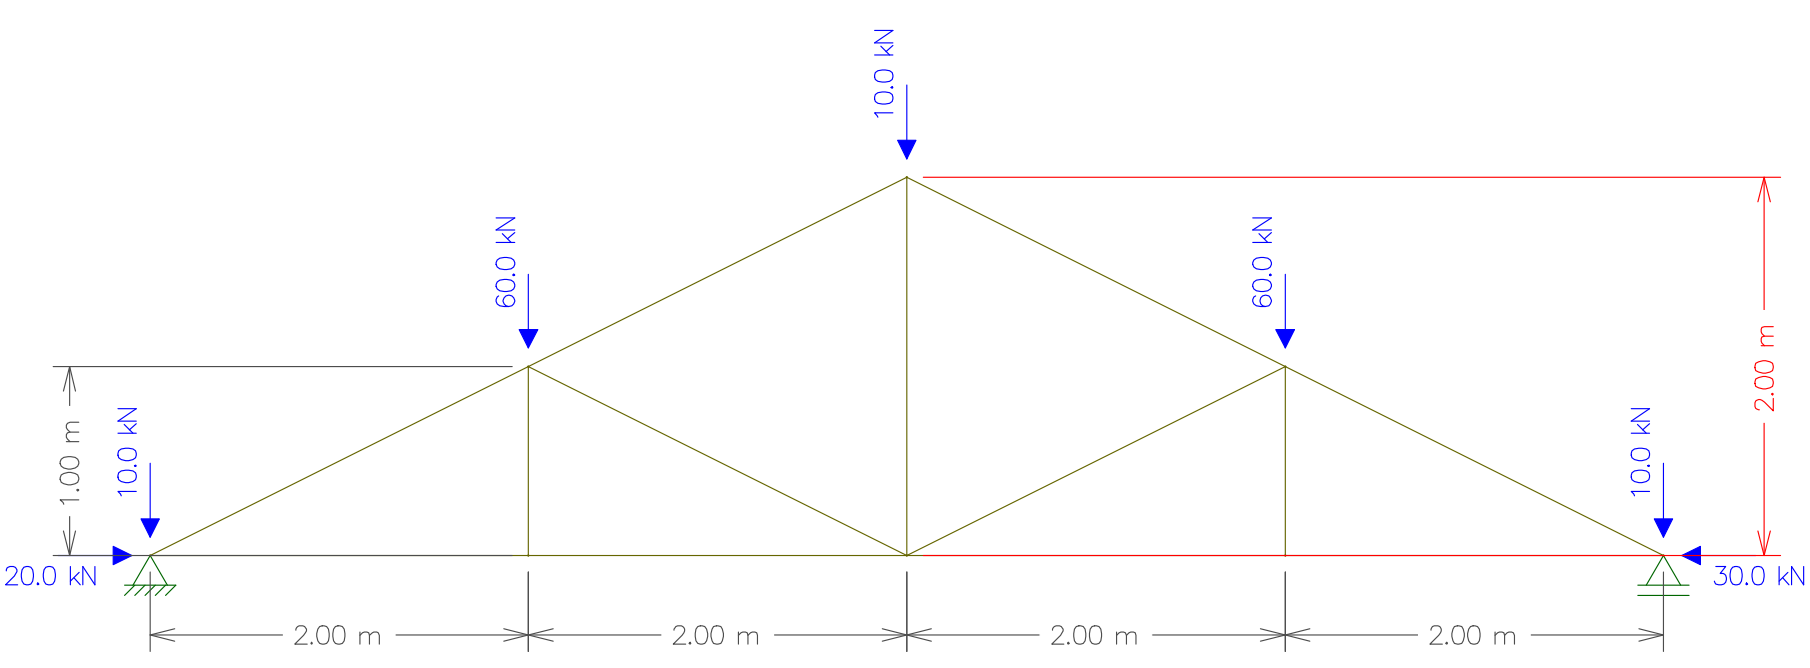

In [224]:
ext_forces = {'A': (20, -10), 'F': (0, -60), 'H': (0, -10), 'G': (0, -60), 'E': (-30, -10)}
virt_in_c = {'C': (0, -1)}

T.process_forces(ext_forces)
T.process_forces(virt_in_c, virtual=True)

TrussManager.show_delta_func_table(T)

Bar     l(m)     N(kN)    n(kN)    Δ(mm)
________________________________________
  1  |  2.00 | 100.00  |  1.00 | -2.000
  2  |  2.00 | 100.00  |  1.00 | -2.000
  3  |  2.00 | 100.00  |  1.00 | -2.000
  4  |  2.00 | 100.00  |  1.00 | -2.000
  5  |  2.24 | -145.34  | -1.12 | -3.634
  6  |  1.00 |   0.00  |  0.00 |  0.000
  7  |  2.24 | -67.08  |  0.00 |  0.000
  8  |  2.00 |  60.00  |  1.00 | -1.200
  9  |  2.24 | -67.08  |  0.00 |  0.000
 10  |  1.00 |   0.00  |  0.00 |  0.000
 11  |  2.24 | -145.34  | -1.12 | -3.634
 12  |  2.24 | -78.26  | -1.12 | -1.957
 13  |  2.24 | -78.26  | -1.12 | -1.957
________________________________________
Total:                       -2.038e+01


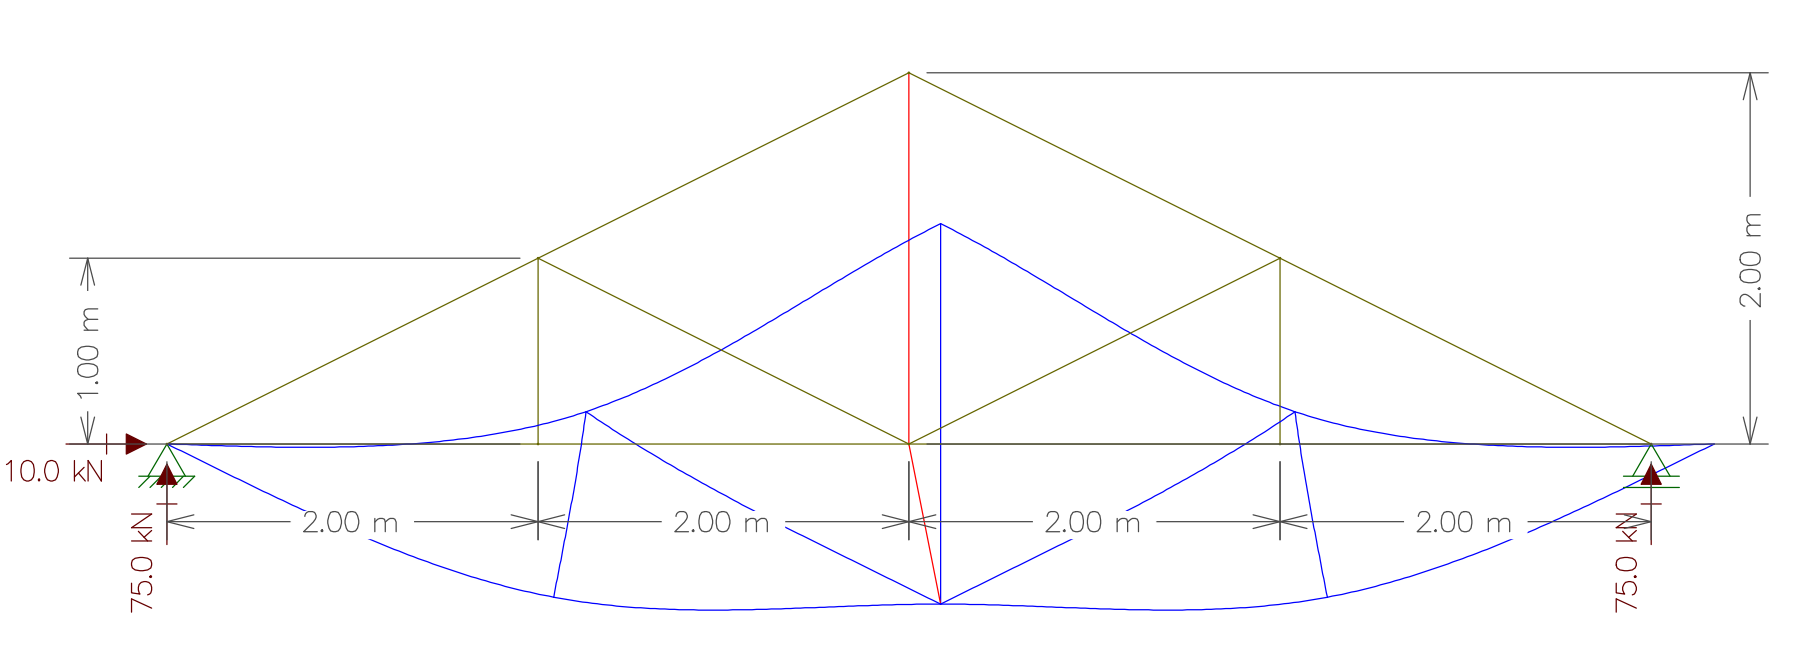

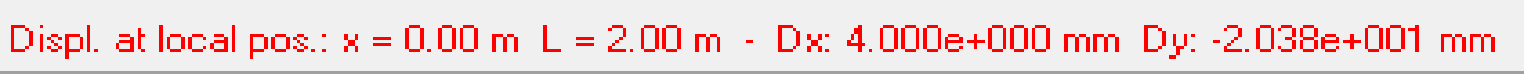

## Teste da função delta para l6 = l8 = l10

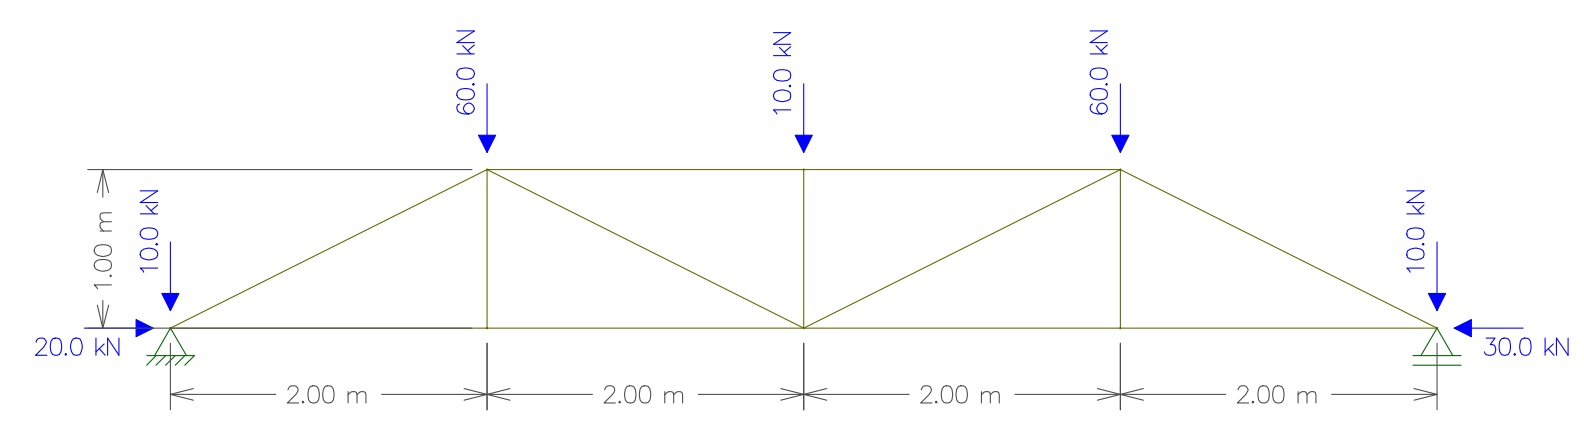

In [225]:
T.update_node_pos('H', (4, 1))

T.process_forces(ext_forces)
T.process_forces(virt_in_c, virtual=True)

TrussManager.show_delta_func_table(T)

Bar     l(m)     N(kN)    n(kN)    Δ(mm)
________________________________________
  1  |  2.00 | 100.00  |  1.00 | -2.000
  2  |  2.00 | 100.00  |  1.00 | -2.000
  3  |  2.00 | 100.00  |  1.00 | -2.000
  4  |  2.00 | 100.00  |  1.00 | -2.000
  5  |  2.24 | -145.34  | -1.12 | -3.634
  6  |  1.00 |   0.00  |  0.00 |  0.000
  7  |  2.24 |  11.18  |  1.12 | -0.280
  8  |  1.00 | -10.00  |  0.00 |  0.000
  9  |  2.24 |  11.18  |  1.12 | -0.280
 10  |  1.00 |   0.00  |  0.00 |  0.000
 11  |  2.24 | -145.34  | -1.12 | -3.634
 12  |  2.00 | -140.00  | -2.00 | -5.600
 13  |  2.00 | -140.00  | -2.00 | -5.600
________________________________________
Total:                       -2.703e+01


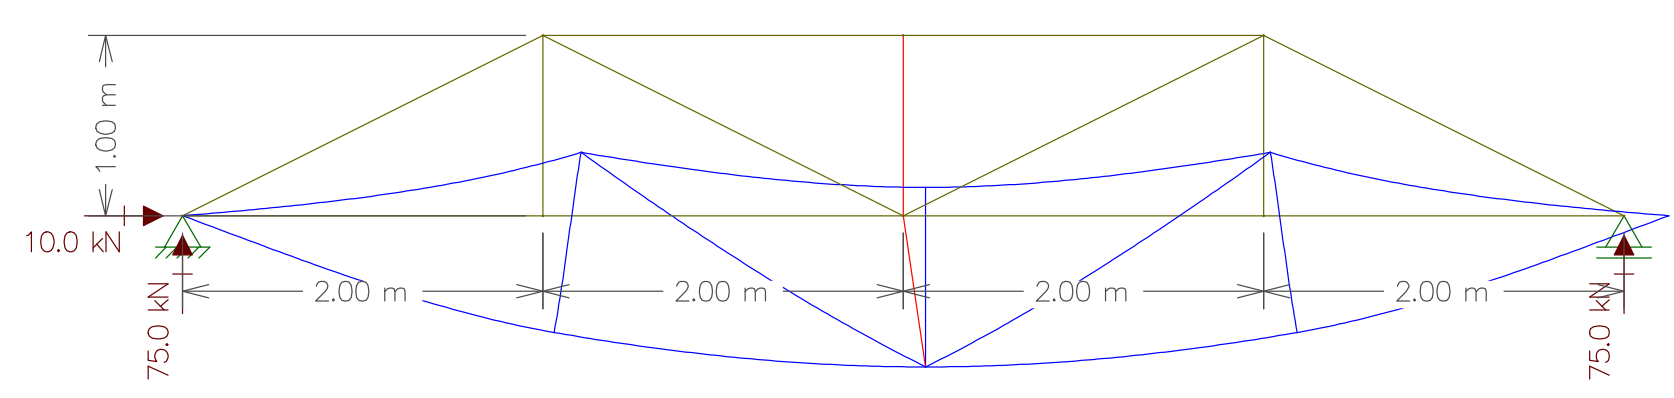

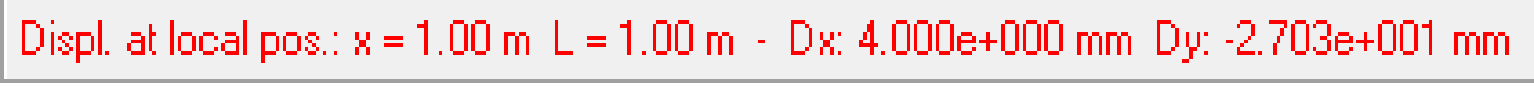

## Teste da função delta para l6 > l8; l8 = l10

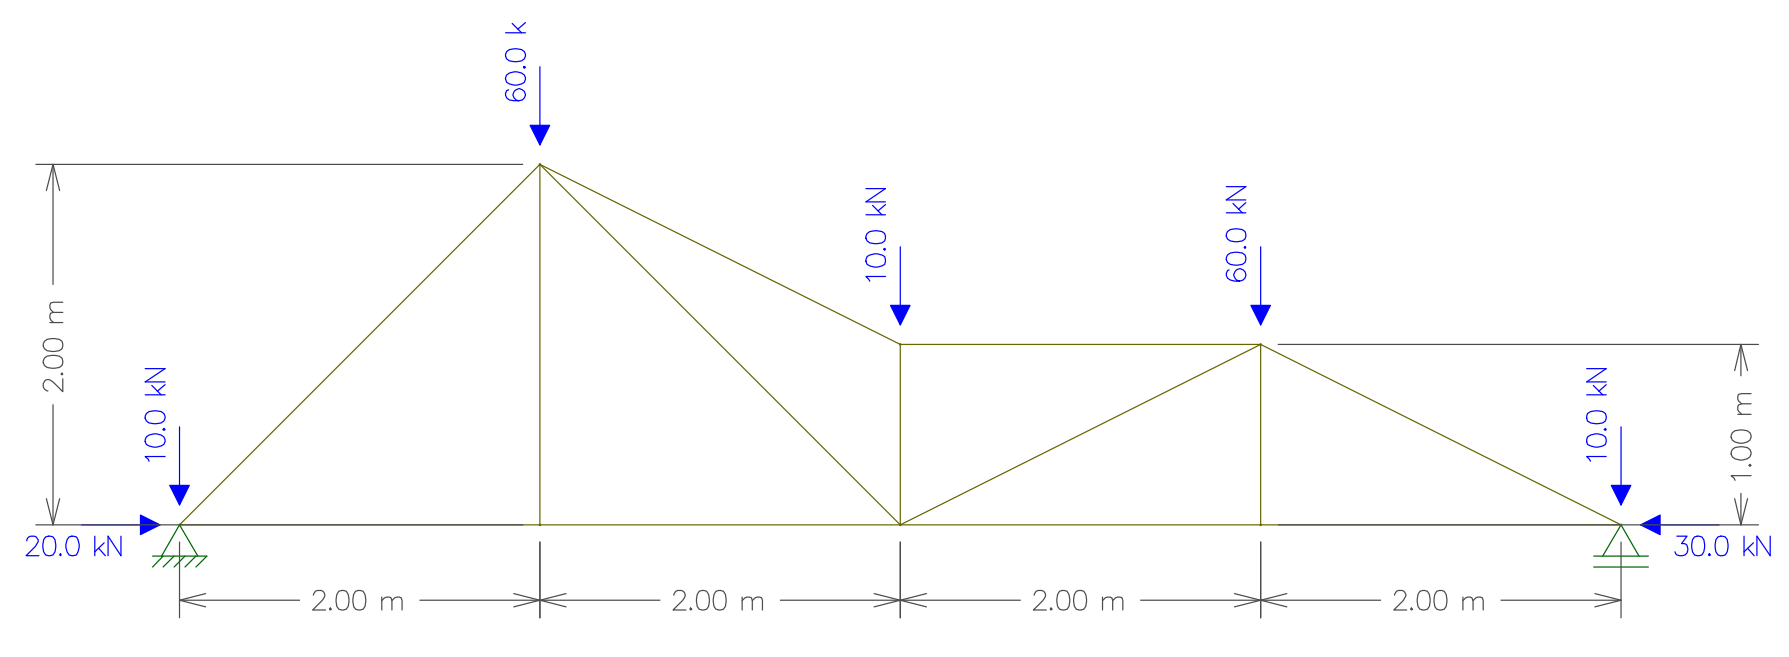

In [226]:
T.update_node_pos('F', (2, 2))

T.process_forces(ext_forces)
T.process_forces(virt_in_c, virtual=True)

TrussManager.show_delta_func_table(T)

Bar     l(m)     N(kN)    n(kN)    Δ(mm)
________________________________________
  1  |  2.00 |  35.00  |  0.50 | -0.350
  2  |  2.00 |  35.00  |  0.50 | -0.350
  3  |  2.00 | 100.00  |  1.00 | -2.000
  4  |  2.00 | 100.00  |  1.00 | -2.000
  5  |  2.83 | -91.92  | -0.71 | -1.838
  6  |  2.00 |   0.00  |  0.00 |  0.000
  7  |  2.83 | 106.07  |  2.12 | -6.364
  8  |  1.00 | -80.00  | -1.00 | -0.800
  9  |  2.24 |  11.18  |  1.12 | -0.280
 10  |  1.00 |   0.00  |  0.00 |  0.000
 11  |  2.24 | -145.34  | -1.12 | -3.634
 12  |  2.24 | -156.52  | -2.24 | -7.826
 13  |  2.00 | -140.00  | -2.00 | -5.600
________________________________________
Total:                       -3.104e+01


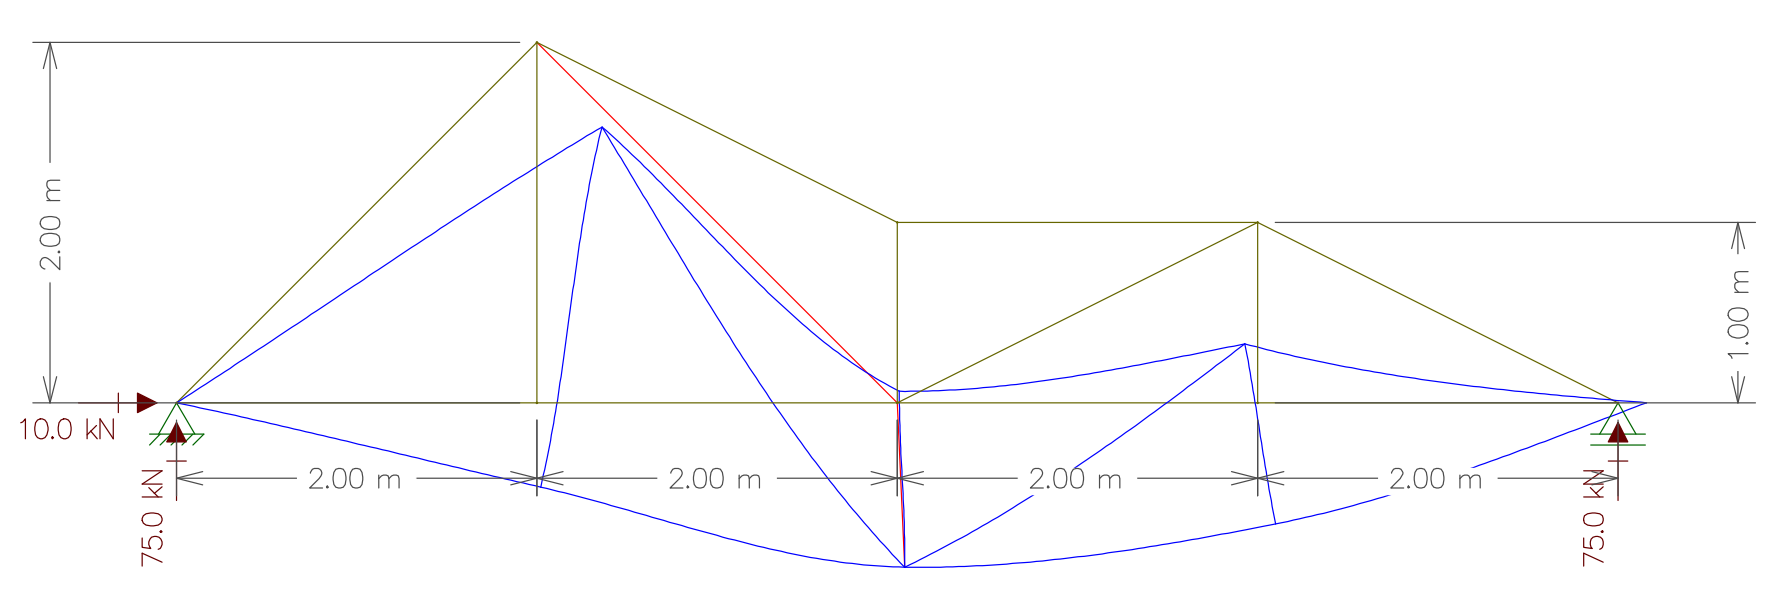

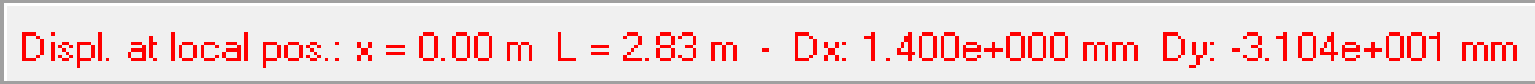

## Teste da função delta para l10 > l6; l8 = l6

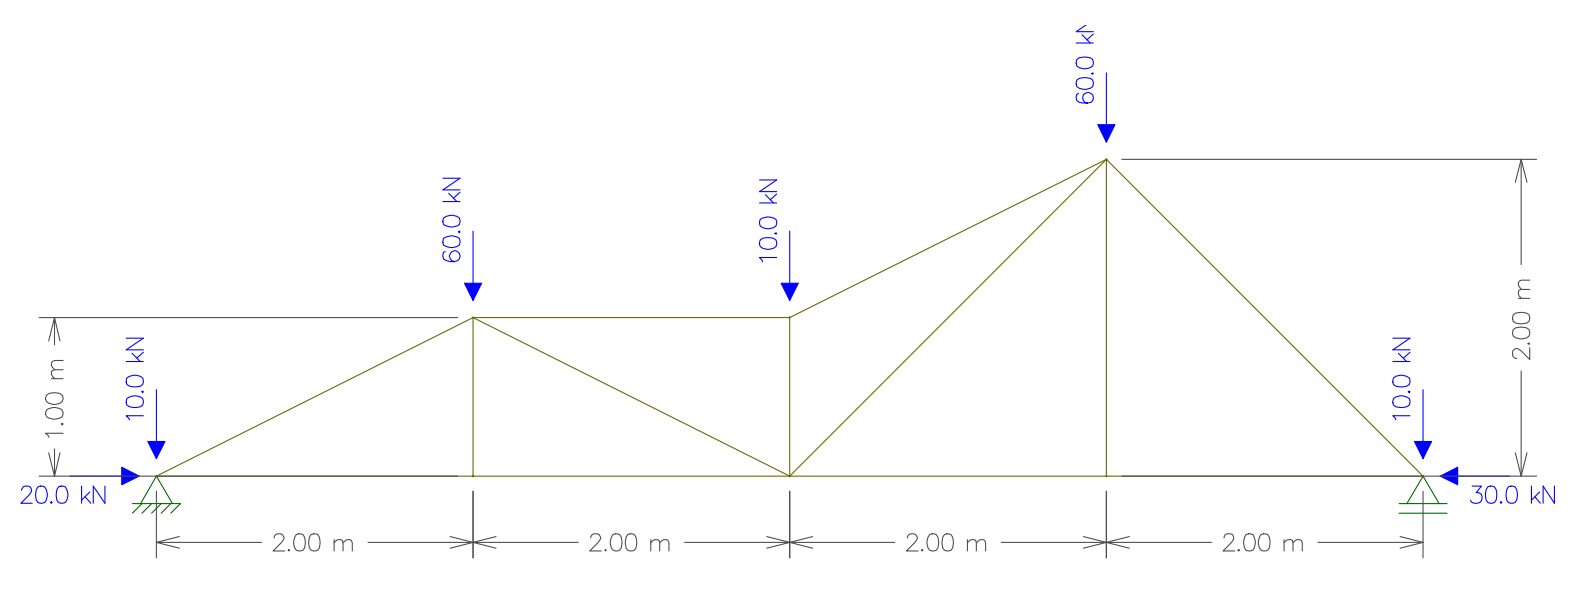

In [227]:
T.update_node_pos('F', (2, 1))
T.update_node_pos('G', (6, 2))

T.process_forces(ext_forces)
T.process_forces(virt_in_c, virtual=True)

TrussManager.show_delta_func_table(T)

Bar     l(m)     N(kN)    n(kN)    Δ(mm)
________________________________________
  1  |  2.00 | 100.00  |  1.00 | -2.000
  2  |  2.00 | 100.00  |  1.00 | -2.000
  3  |  2.00 |  35.00  |  0.50 | -0.350
  4  |  2.00 |  35.00  |  0.50 | -0.350
  5  |  2.24 | -145.34  | -1.12 | -3.634
  6  |  1.00 |   0.00  |  0.00 |  0.000
  7  |  2.24 |  11.18  |  1.12 | -0.280
  8  |  1.00 | -80.00  | -1.00 | -0.800
  9  |  2.83 | 106.07  |  2.12 | -6.364
 10  |  2.00 |   0.00  |  0.00 |  0.000
 11  |  2.83 | -91.92  | -0.71 | -1.838
 12  |  2.00 | -140.00  | -2.00 | -5.600
 13  |  2.24 | -156.52  | -2.24 | -7.826
________________________________________
Total:                       -3.104e+01


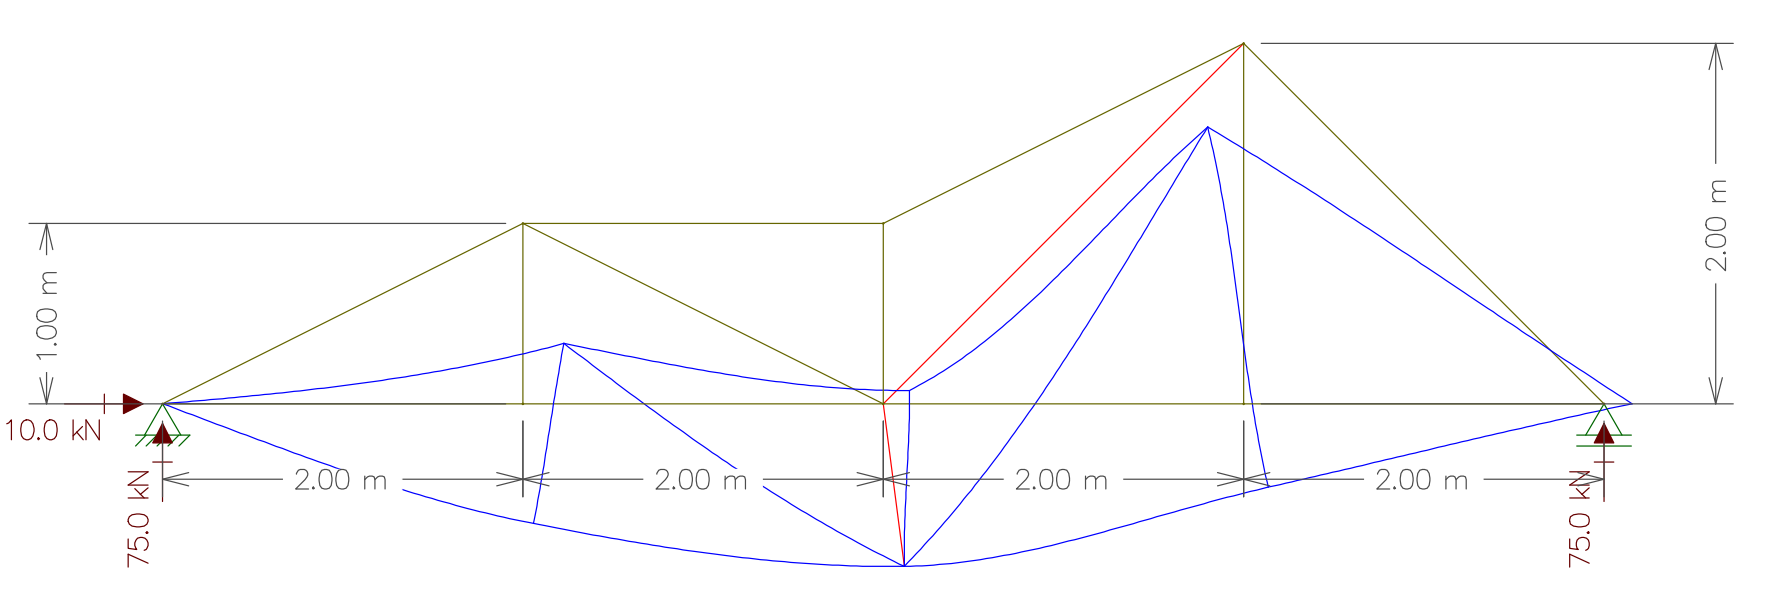

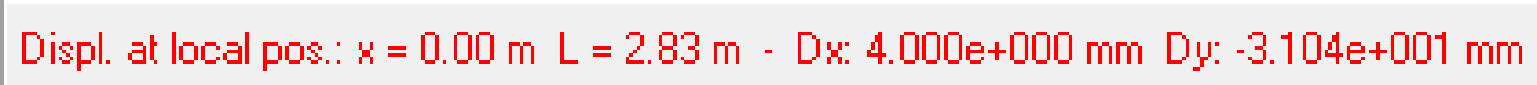

## Teste da função delta para l8 < l6; l6 = l10

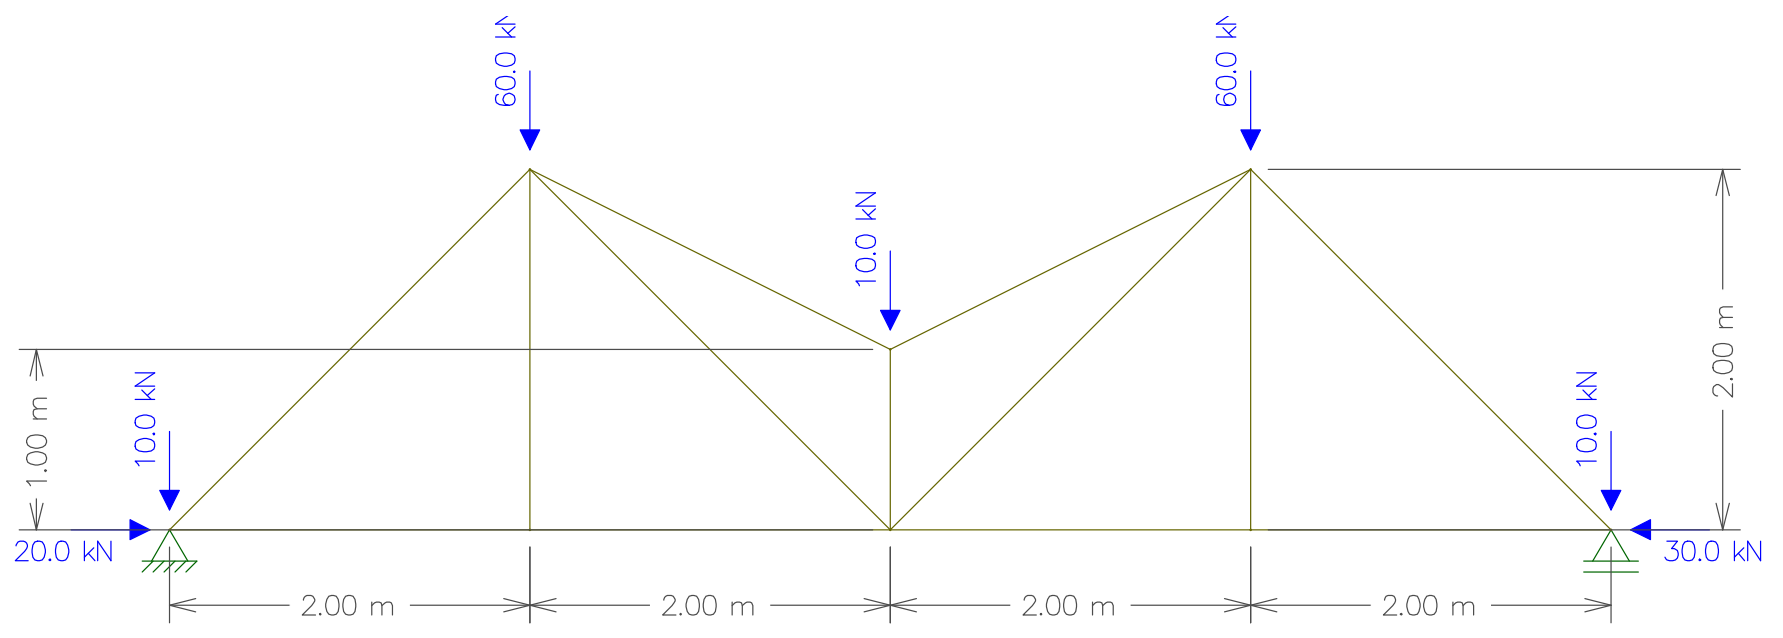

In [228]:
T.update_node_pos('F', (2, 2))

T.process_forces(ext_forces)
T.process_forces(virt_in_c, virtual=True)

TrussManager.show_delta_func_table(T)

Bar     l(m)     N(kN)    n(kN)    Δ(mm)
________________________________________
  1  |  2.00 |  35.00  |  0.50 | -0.350
  2  |  2.00 |  35.00  |  0.50 | -0.350
  3  |  2.00 |  35.00  |  0.50 | -0.350
  4  |  2.00 |  35.00  |  0.50 | -0.350
  5  |  2.83 | -91.92  | -0.71 | -1.838
  6  |  2.00 |   0.00  |  0.00 |  0.000
  7  |  2.83 | 106.07  |  2.12 | -6.364
  8  |  1.00 | -150.00  | -2.00 | -3.000
  9  |  2.83 | 106.07  |  2.12 | -6.364
 10  |  2.00 |   0.00  |  0.00 |  0.000
 11  |  2.83 | -91.92  | -0.71 | -1.838
 12  |  2.24 | -156.52  | -2.24 | -7.826
 13  |  2.24 | -156.52  | -2.24 | -7.826
________________________________________
Total:                       -3.646e+01


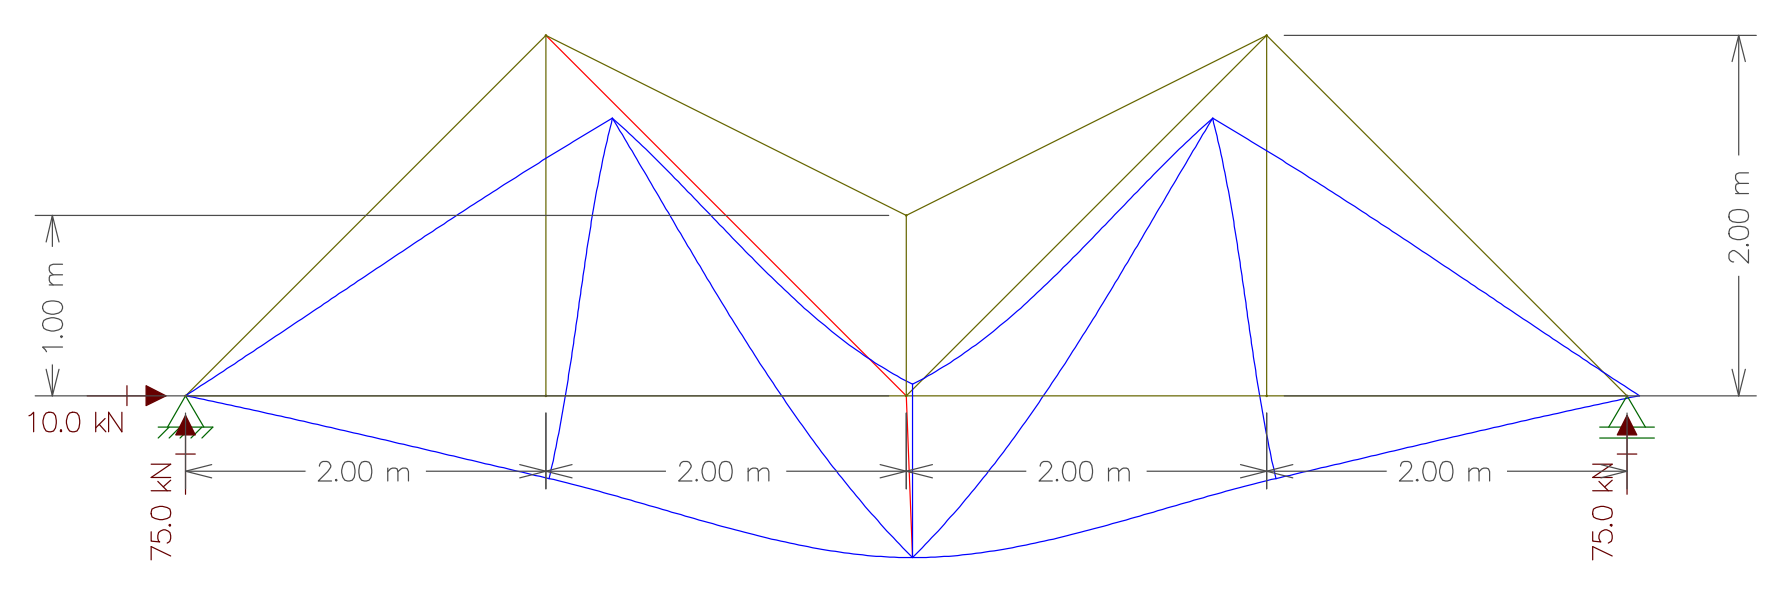

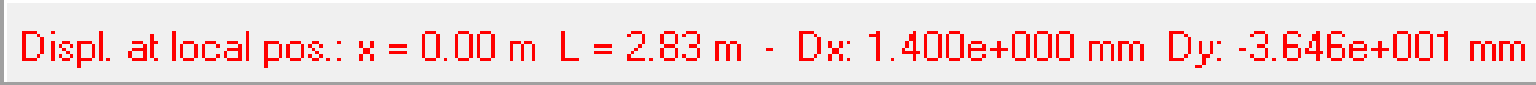

## Teste da função delta para l8 < l6 < l10

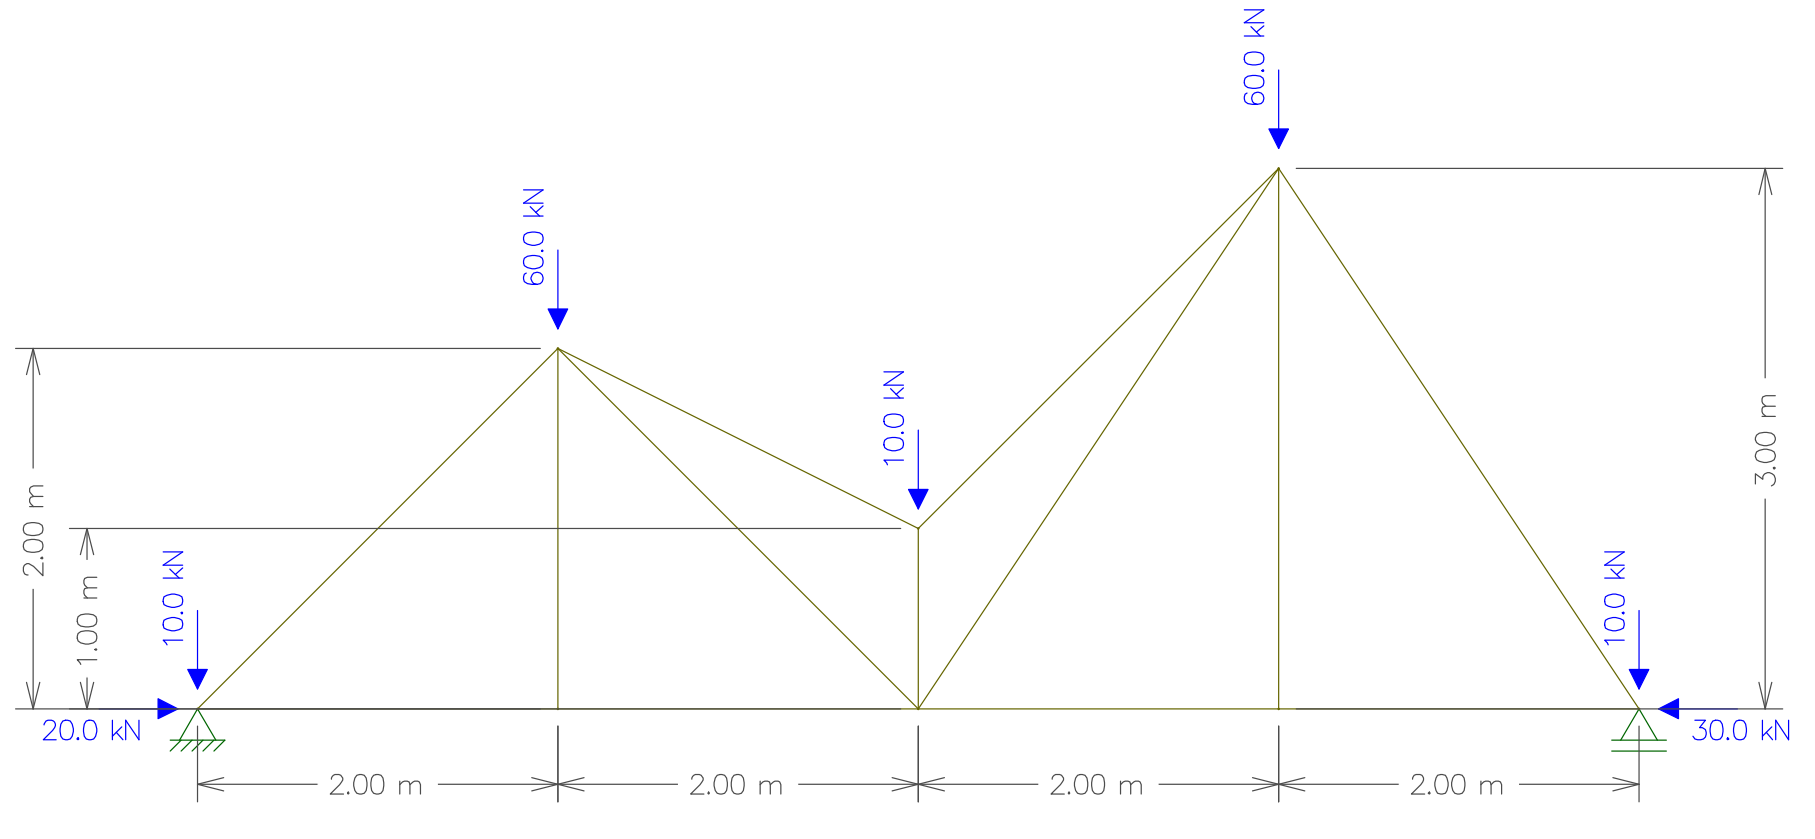

In [229]:
T.update_node_pos('G', (6, 3))

T.process_forces(ext_forces)
T.process_forces(virt_in_c, virtual=True)

TrussManager.show_delta_func_table(T)

Bar     l(m)     N(kN)    n(kN)    Δ(mm)
________________________________________
  1  |  2.00 |  35.00  |  0.50 | -0.350
  2  |  2.00 |  35.00  |  0.50 | -0.350
  3  |  2.00 |  13.33  |  0.33 | -0.089
  4  |  2.00 |  13.33  |  0.33 | -0.089
  5  |  2.83 | -91.92  | -0.71 | -1.838
  6  |  2.00 |   0.00  |  0.00 |  0.000
  7  |  2.83 | 106.07  |  2.12 | -6.364
  8  |  1.00 | -220.00  | -3.00 | -6.600
  9  |  3.61 | 174.27  |  3.00 | -18.879
 10  |  3.00 |   0.00  |  0.00 |  0.000
 11  |  3.61 | -78.12  | -0.60 | -1.693
 12  |  2.24 | -156.52  | -2.24 | -7.826
 13  |  2.83 | -197.99  | -2.83 | -15.839
________________________________________
Total:                       -5.992e+01


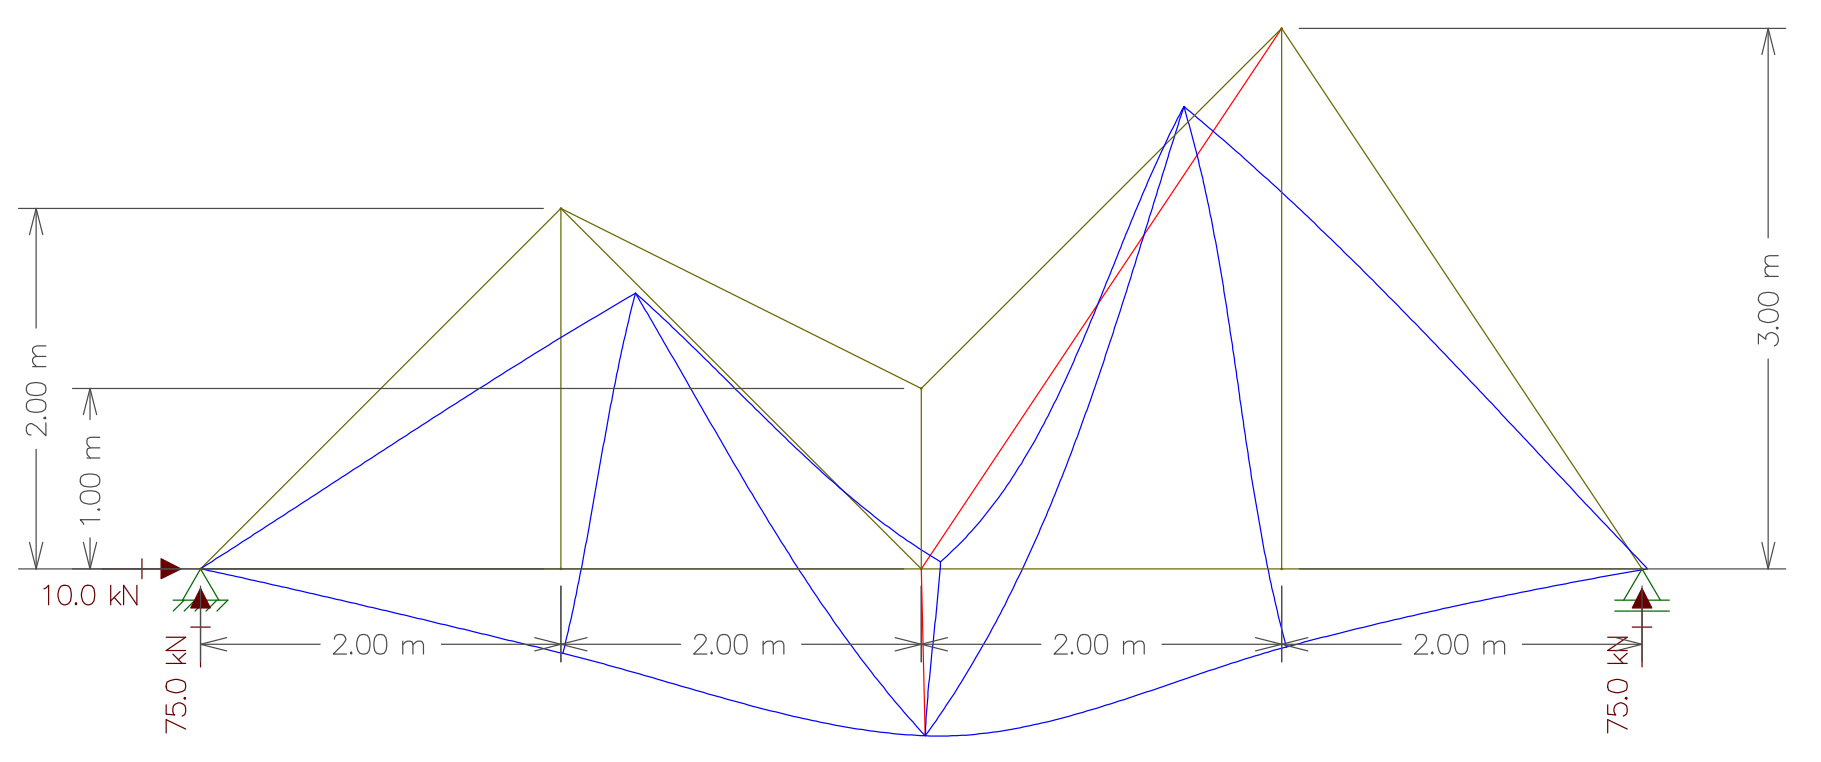

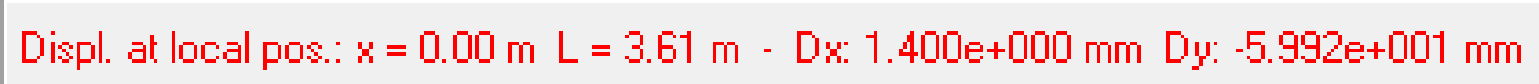

## Algoritmo Genético - Evolução da Treliça

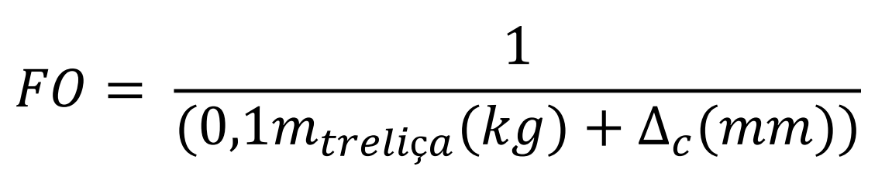

In [230]:
from random import choice, randint, random

class Chromosome:
  def __init__(self, possible_values):
    self.possible_values = possible_values
    self.value = choice(possible_values)
    self.ref_obj = None

  def mutate(self):
    self.value = choice(self.possible_values)

class TrussIndividual(Truss):
  def __init__(self, generation, areas_chromosome, lengths_chromosome=None):
    super().__init__([
        SupportNode('A', pos=(0, 0)), Node('B', pos=(2, 0)), Node('C', pos=(4, 0)), Node('D', pos=(6, 0)),
        SupportNode('E', pos=(8, 0)), Node('F', pos=(2, 2)), Node('G', pos=(6, 2)), Node('H', pos=(4, 3))
    ] if lengths_chromosome is None else [
        SupportNode('A', pos=(0, 0)), Node('B', pos=(2, 0)), Node('C', pos=(4, 0)), Node('D', pos=(6, 0)),
        SupportNode('E', pos=(8, 0)), Node('F', pos=(2, lengths_chromosome[0].value)), Node('G', pos=(6, lengths_chromosome[1].value)),
        Node('H', pos=(4, lengths_chromosome[2].value))
    ])
    self.generation = generation
    self.score = 0
    self.areas_chromosome = areas_chromosome
    self.lengths_chromosome = lengths_chromosome

    self.add_bars([ 
      Bar(k, areas_chromosome[i].value) for i, k in enumerate([
        'AB', 'AF', 'BF', 'BC', 'CF', 'CD', 'CG',
        'DG', 'DE', 'EG', 'FH', 'CH', 'GH'
      ])
    ])

    for i, k in enumerate(['AB', 'AF', 'BF', 'BC', 'CF', 'CD', 'CG',
                           'DG', 'DE', 'EG', 'FH', 'CH', 'GH']):
      if lengths_chromosome is not None:
        self.bars[k].process_bar_length()
      areas_chromosome[i].ref_obj = self.bars[k]

    if lengths_chromosome is not None:
      for i, k in enumerate(['BF', 'CH', 'DG']):
        lengths_chromosome[i].ref_obj = self.bars[k]
    
    self.process_forces({'A': (0, 0), 'F': (0, -55), 'H': (0, -20), 'G': (0, -40), 'E': (0, -10)})
    self.process_forces({'C': (0, -1)}, virtual=True)
    self.process_bars_delta()
    self.fitness()

  def fitness(self) -> None:
    self.score = 1/(0.1*self.mass + abs(self.total_delta))

  def mutated(self, mutation_rate):
    for area in self.areas_chromosome: 
      if random() < mutation_rate:
        area.mutate()
        area.ref_obj.area = area.value
    if self.lengths_chromosome is not None:
      for length in self.lengths_chromosome:
        if random() < mutation_rate:
          length.mutate()
          length.ref_obj.l = length.value
      for bar in self.bars.values():
        bar.process_bar_length()
    self.process_bars_delta()
    self.fitness()
    return self

  def crossover(self, T):
    area_cut = randint(0, len(self.areas_chromosome))
    length_cut = randint(0, len(self.lengths_chromosome)) if self.lengths_chromosome is not None else None

    c1_areas_chromosome = T.areas_chromosome[:area_cut] + self.areas_chromosome[area_cut:]
    c2_areas_chromosome = self.areas_chromosome[:area_cut] + T.areas_chromosome[area_cut:]
    c1_lengths_chromosome = T.lengths_chromosome[:length_cut] + self.lengths_chromosome[length_cut:] if self.lengths_chromosome is not None else None
    c2_lengths_chromosome = self.lengths_chromosome[:length_cut] + T.lengths_chromosome[length_cut:] if T.lengths_chromosome is not None else None

    return TrussIndividual(T.generation+1, c1_areas_chromosome, c1_lengths_chromosome), TrussIndividual(T.generation+1, c2_areas_chromosome, c2_lengths_chromosome)

class TrussGeneticAlgorithm:
  def __init__(self, population_capacity, possible_areas: list, possible_lengths=None, mutation_rate=0.05):
    self.population: list[TrussIndividual] = []
    self.best_truss: TrussIndividual = None
    self.possible_areas = possible_areas
    self.possible_lengths = possible_lengths
    self.population_capacity = population_capacity
    self.total_score = 0.0
    self.mutation_rate = mutation_rate

    # Initial population
    for i in range(self.population_capacity):
      areas_chromosome = [Chromosome(self.possible_areas) for _ in range(13)]
      lengths_chromosome = [Chromosome(self.possible_lengths) for _ in range(3)] if self.possible_lengths is not None else None # F, H, G lengths
      truss_individual = TrussIndividual(1, areas_chromosome, lengths_chromosome)
      truss_individual.fitness()
      self.population.append(truss_individual)
    self.sort_population()
    self.best_truss = self.population[0]
    

  def run(self, generation_count: int) -> None:
    for i in range(generation_count):
      self.total_score = sum(ind.score for ind in self.population)
      new_population = []
      for _ in range(0, self.population_capacity-1, 2):
        father1 = self.get_father()
        father2 = self.get_father()

        children = father1.crossover(father2)
        new_population.append(children[0].mutated(self.mutation_rate))
        new_population.append(children[1].mutated(self.mutation_rate))

      new_population.append(self.population[0])
      self.population = list(new_population)
      for ind in self.population:
        ind.fitness()
      self.sort_population()
      possible_best_ind = self.population[0]
      if possible_best_ind.score > self.best_truss.score:
        self.best_truss = possible_best_ind

    return self.best_truss

  def sort_population(self):
    self.population.sort(key=lambda x: x.score, reverse=True)

  # Roulette wheel selection method
  def get_father(self) -> TrussIndividual:
    drawn_value = random() * self.total_score
    score_amount = 0
    chosen_father_idx = -1
    i = 0
    while i < len(self.population) and score_amount < drawn_value:
      score_amount += self.population[i].score
      chosen_father_idx += 1
      i += 1

    return self.population[chosen_father_idx]

## Caso 1: Maximizar FO para as seguintes possíveis áreas de seção transversal das barras:

\begin{align}
  \{A_1;...A_{13}\} = \{3×10^{-4}m^2;\ 4×10^{-4}m^2;\ 5×10^{-4}m^2\}
\end{align}

In [239]:
case_1_ag = TrussGeneticAlgorithm(
  population_capacity=500,
  possible_areas=[3/10**4, 4/10**4, 5/10**4]
)

case_1_best_truss = case_1_ag.run(500)

TrussManager.show_delta_func_table(case_1_best_truss)

Bar     l(m)     N(kN)    n(kN)    Δ(mm)
________________________________________
  1  |  2.00 |  61.25  |  0.50 | -0.766
  2  |  2.00 |  61.25  |  0.50 | -0.766
  3  |  2.00 |  53.75  |  0.50 | -0.672
  4  |  2.00 |  53.75  |  0.50 | -0.672
  5  |  2.83 | -86.62  | -0.71 | -1.732
  6  |  2.00 |   0.00  |  0.00 |  0.000
  7  |  2.83 | -22.98  |  0.24 |  0.255
  8  |  3.00 |  25.00  |  0.67 | -0.833
  9  |  2.83 | -12.37  |  0.24 |  0.137
 10  |  2.00 |   0.00  |  0.00 |  0.000
 11  |  2.83 | -76.01  | -0.71 | -1.520
 12  |  2.24 | -50.31  | -0.75 | -0.839
 13  |  2.24 | -50.31  | -0.75 | -0.839
________________________________________
Total:                       -8.245e+00


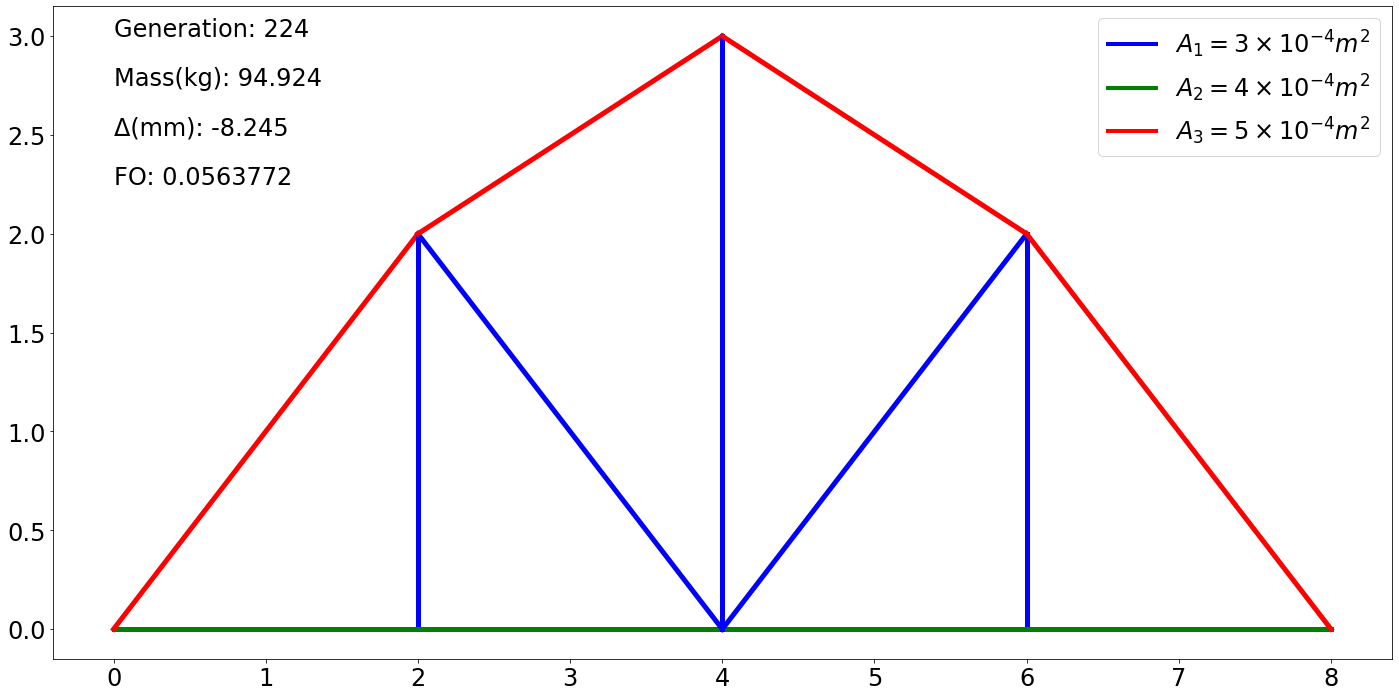

In [240]:
TrussManager.plot_truss(case_1_best_truss)

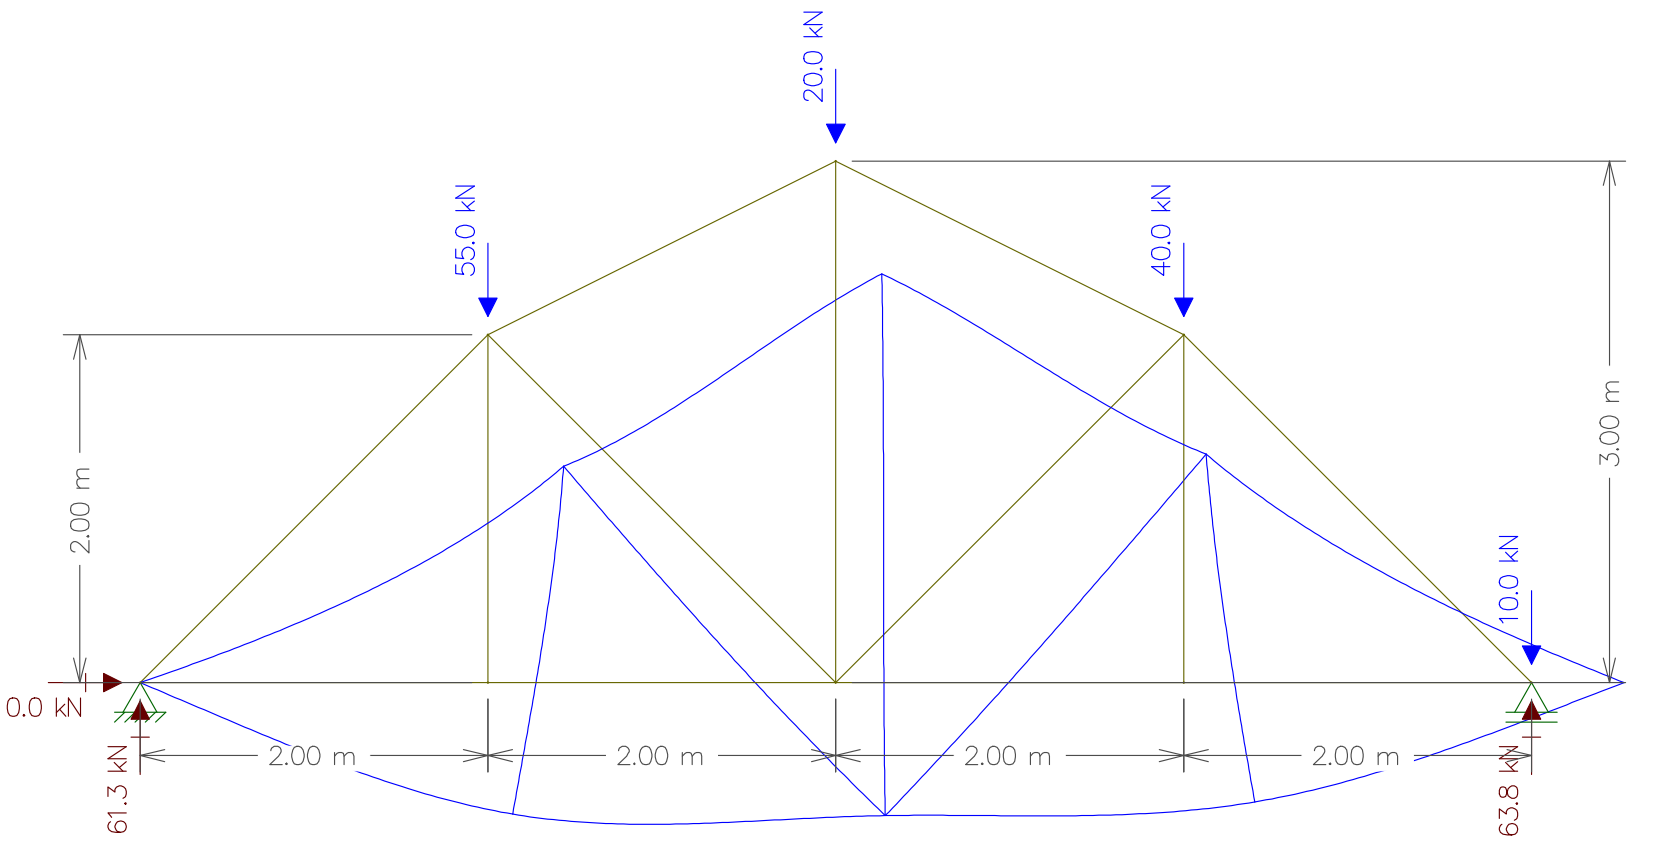

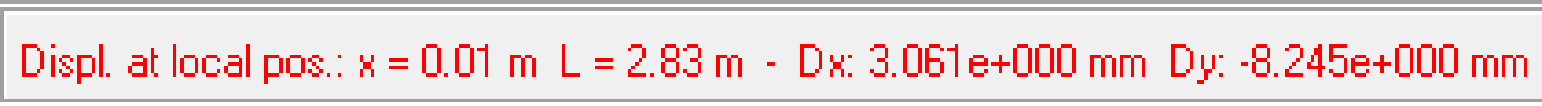

## Caso 2: Maximizar FO para as seguintes possíveis áreas de seção transversal das barras:

## \begin{align}
  \{A_1;...A_{13}\} = \{3×10^{-4}m^2;\ 4×10^{-4}m^2;\ 5×10^{-4}m^2\}
\end{align}

## E para os seguintes possíveis comprimentos das barras l6, l8 e l10:
## \begin{align}
  \{l_6;l_8;l_{10}\} = \{1m;\ 2m;\ 3m\}
\end{align}

In [273]:
case_2_ag = TrussGeneticAlgorithm(
  population_capacity=500,
  possible_areas=[3/10**4, 4/10**4, 5/10**4],  # m²
  possible_lengths=[1, 2, 3]  # m
)

case_2_best_truss = case_2_ag.run(500)
TrussManager.show_delta_func_table(case_2_best_truss)

Bar     l(m)     N(kN)    n(kN)    Δ(mm)
________________________________________
  1  |  2.00 |  40.83  |  0.33 | -0.454
  2  |  2.00 |  40.83  |  0.33 | -0.454
  3  |  2.00 |  53.75  |  0.50 | -0.672
  4  |  2.00 |  53.75  |  0.50 | -0.672
  5  |  3.61 | -73.61  | -0.60 | -1.595
  6  |  3.00 |   0.00  |  0.00 |  0.000
  7  |  3.61 |   7.51  |  0.60 | -0.271
  8  |  3.00 |   2.50  |  0.33 | -0.042
  9  |  2.83 | -12.37  |  0.24 |  0.137
 10  |  2.00 |   0.00  |  0.00 |  0.000
 11  |  2.83 | -76.01  | -0.71 | -1.520
 12  |  2.00 | -45.00  | -0.67 | -0.750
 13  |  2.24 | -50.31  | -0.75 | -0.839
________________________________________
Total:                       -7.130e+00


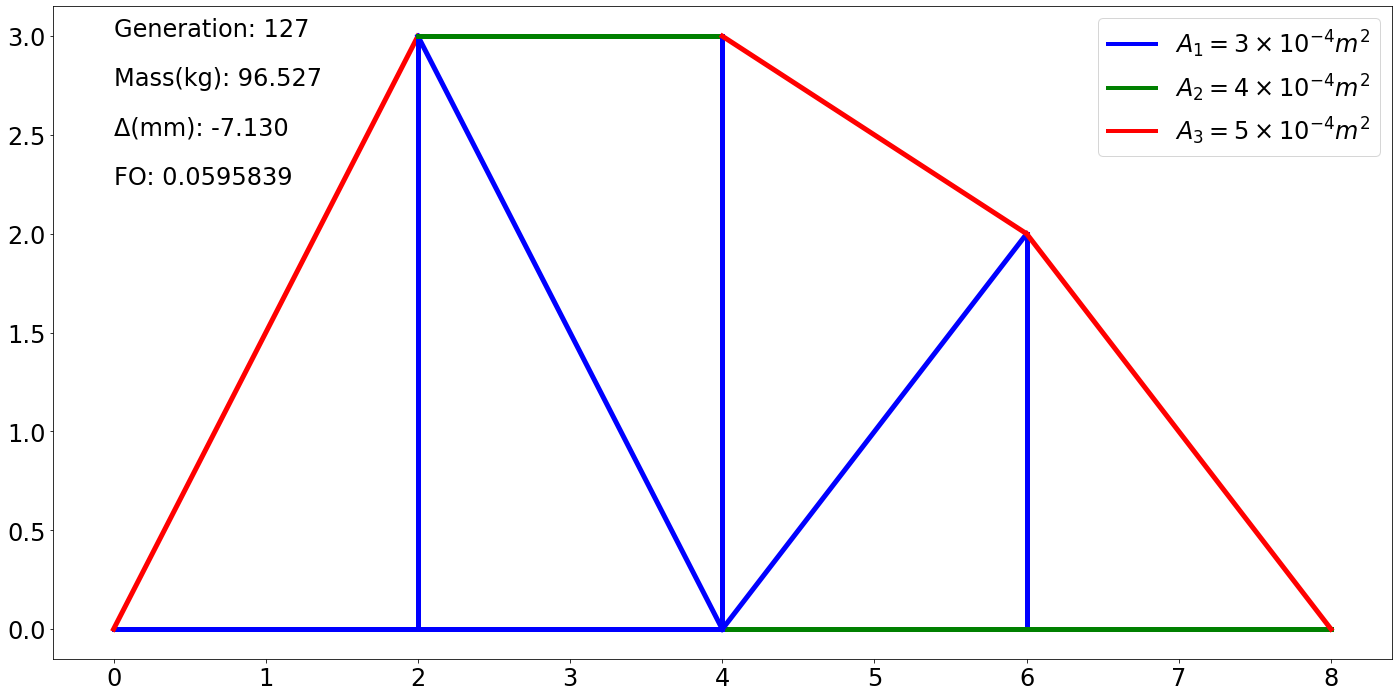

In [274]:
TrussManager.plot_truss(case_2_best_truss)

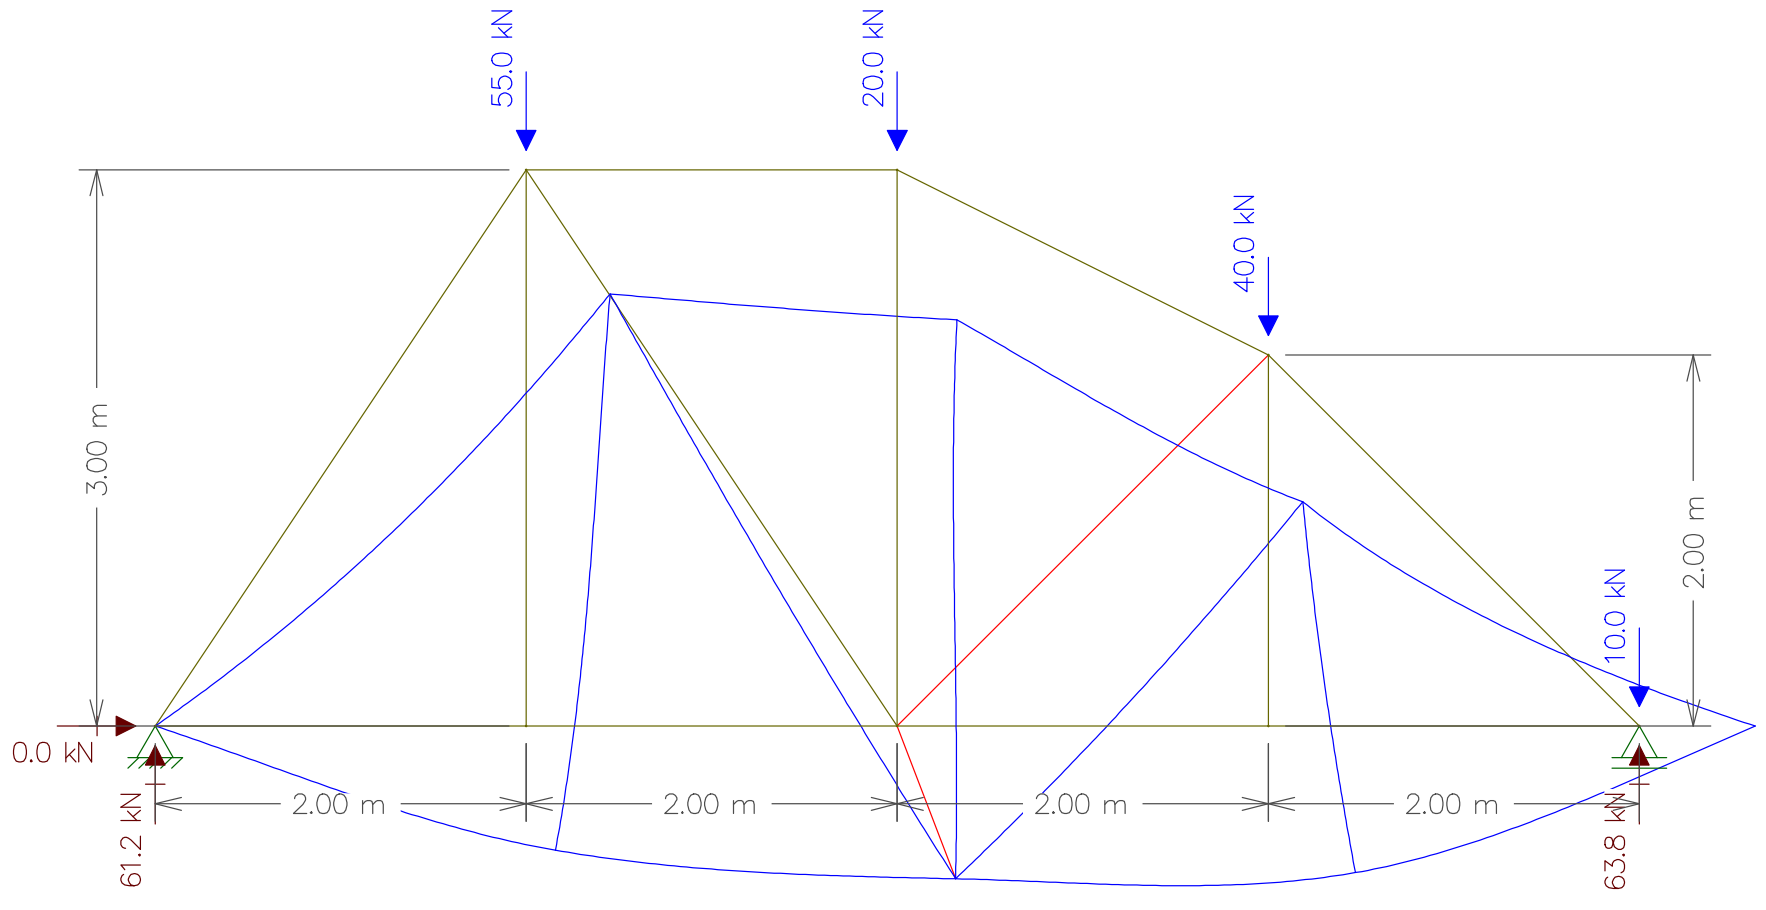

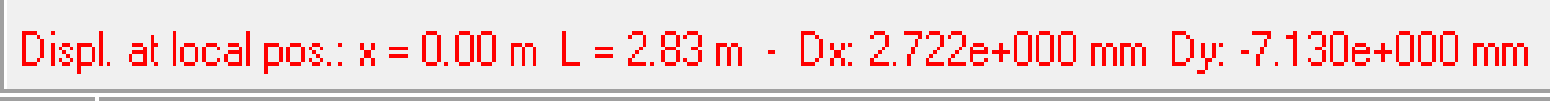